In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# test
def df_has_only_numeric_columns(df):
    assert df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all()).all()

In [3]:
def preprocess_object_features():
    df_tr = pd.read_csv("../data/raw/training_v2.csv")

    df_train = df_tr.copy()

    # drop readmission_status as it has all 0
    df_train.drop('readmission_status', axis=1, inplace=True)
    df_train.drop('encounter_id', axis=1, inplace=True)
    df_train.drop('patient_id', axis=1, inplace=True)
    df_train.drop('hospital_id', axis=1, inplace=True)
    df_train.drop('icu_id', axis=1, inplace=True)

    # 25 genders are nan => replace them with 'M'
    df_train['gender'] = df_train['gender'].fillna(df_train['gender'].value_counts().index[0])
    df_train['gender'] = df_train['gender'].map({'M': 0, 'F': 1})
    
    df_train['ethnicity'] = df_train['ethnicity'].fillna("Other/Unknown")
        
    df_train['hospital_admit_source'] = df_train['hospital_admit_source'].fillna("Other")

    df_train['icu_stay_type'] = df_train['icu_stay_type'].fillna(df_train['icu_stay_type'].value_counts().index[0])
    df_train['icu_stay_type'] = df_train['icu_stay_type'].map({'admit': 0, 'transfer': 1})
    
    # remove outliers
    df_train = df_train[df_train["pre_icu_los_days"] < 88]
    df_train["pre_icu_los_days"] = np.maximum(0, df_train["pre_icu_los_days"])
    
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df_train["apache_2_bodysystem"].replace(und_diag, inplace = True)

    cat_columns = ["ethnicity", "hospital_admit_source",
                   "icu_admit_source", "icu_type",
                   "apache_3j_bodysystem", "apache_2_bodysystem"]

    df_train = pd.get_dummies(df_train, columns=cat_columns)

    df_train.fillna(df_train.mean(), inplace=True)


    df_has_only_numeric_columns(df_train)

    return df_train

In [4]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.3f}".format(acc))
    print("Precision: {:.3f}".format(precision))
    print("Recall:    {:.3f}".format(recall))
    print("F1-score:  {:.3f}".format(f1))
    print("ROCAUC:    {:.3f}".format(roc_auc))
    print("AUPRC:     {:.3f}".format(auprc))

In [5]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [6]:
clean_df = preprocess_object_features()

y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [7]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [8]:
y_true = y_test.values

y_score = rf_clf.predict_proba(X_test)
y_pred = rf_clf.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.930
Precision: 0.743
Recall:    0.296
F1-score:  0.423
ROCAUC:    0.885
AUPRC:     0.544


Text(0.5, 1.0, '2-class Precision-Recall curve')

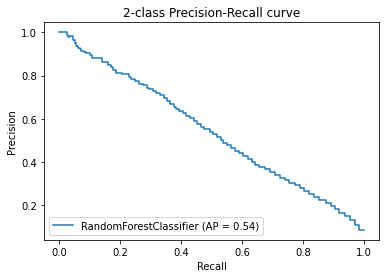

In [11]:
disp = plot_precision_recall_curve(rf_clf, X_test, y_true)
disp.ax_.set_title('2-class Precision-Recall curve')

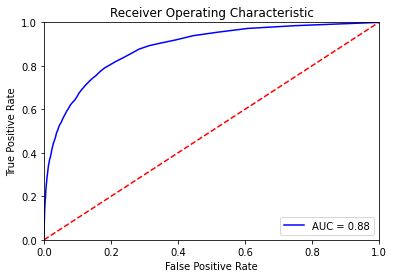

In [12]:
plot_roc_curve(y_true, y_score[:, 1])

In [13]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [14]:
y_score_gb = gb_clf.predict_proba(X_test)
y_pred_gb = gb_clf.predict(X_test)

evaluate(y_true, y_score_gb[:, 1], y_pred_gb)

Accuracy:  0.931
Precision: 0.702
Recall:    0.343
F1-score:  0.461
ROCAUC:    0.895
AUPRC:     0.563


In [15]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                        sampling_strategy='auto',
                        max_samples=0.4, # 0.4, 0.5
                        n_estimators=100, # try
                        bootstrap=False, # try
                        replacement=False,
                        random_state=0)


#Train the classifier.
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                p

In [16]:
# 0.4
y_score_bbc = bbc.predict_proba(X_test)
y_pred_bbc = bbc.predict(X_test)

evaluate(y_true, y_score_bbc[:, 1], y_pred_bbc)

Accuracy:  0.799
Precision: 0.275
Recall:    0.814
F1-score:  0.411
ROCAUC:    0.885
AUPRC:     0.459
